<a href="https://colab.research.google.com/github/zuulaika/Projet-python/blob/main/Taux_criminalit%C3%A9_r%C3%A9partition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taux de Criminalité 2019 vs 2024

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [20]:
!pip install pandas fiona shapely pyproj rtree geopandas

In [22]:
import pandas as pd
import geopandas as gpd

In [23]:
!pip install cartiflette
from cartiflette import carti_download

departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

Reprojeter les données en Lambert 93 (EPSG: 2154) (Le Lambert 93 a été conçu pour être le moins déformant possible sur la France métropolitaine).

In [24]:
departements_lambert93 = departements.to_crs(epsg=2154)


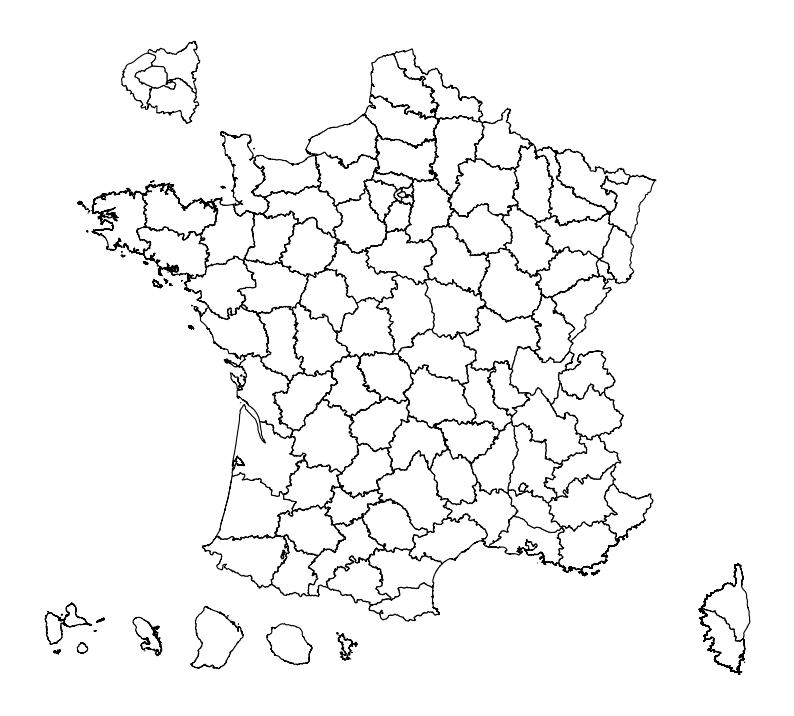

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
departements_lambert93.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
ax.set_axis_off()

In [26]:
#Préparer les données de criminalité pour le calcul de la moyenne
url = "https://www.data.gouv.fr/fr/datasets/r/8debb975-02da-4bfc-808f-42d18ad76d0b"
df = pd.read_csv(url, sep=';', dtype=str)



In [27]:
print(df['indicateur'].unique())

['Homicides' "Tentatives d'homicides" 'Coups et blessures volontaires'
 'Coups et blessures volontaires intrafamiliaux'
 'Autres coups et blessures volontaires' 'Violences sexuelles'
 'Vols avec armes' 'Vols violents sans arme'
 'Vols sans violence contre des personnes' 'Cambriolages de logement'
 'Vols de véhicules' 'Vols dans les véhicules'
 "Vols d'accessoires sur véhicules"
 'Destructions et dégradations volontaires' 'Usage de stupéfiants'
 'Usage de stupéfiants (AFD)' 'Trafic de stupéfiants' 'Escroqueries']


In [28]:
#On définit des poids à chaque type de crime selon a gravité

crime_weights = {
    'Homicides': 10,
    "Tentatives d'homicides": 9,
    'Coups et blessures volontaires': 5,
    'Coups et blessures volontaires intrafamiliaux': 6,
    'Autres coups et blessures volontaires': 4,
    'Violences sexuelles': 8,
    'Vols avec armes': 7,
    'Vols violents sans arme': 6,
    'Vols sans violence contre des personnes': 3,
    'Cambriolages de logement': 5,
    'Vols de véhicules': 4,
    'Vols dans les véhicules': 2,
    "Vols d'accessoires sur véhicules": 2,
    'Destructions et dégradations volontaires': 3,
    'Usage de stupéfiants': 1,
    'Usage de stupéfiants (AFD)': 1,
    'Trafic de stupéfiants': 5,
    'Escroqueries': 3
}

print("Crime weights dictionary created:")
print(crime_weights)

Crime weights dictionary created:
{'Homicides': 10, "Tentatives d'homicides": 9, 'Coups et blessures volontaires': 5, 'Coups et blessures volontaires intrafamiliaux': 6, 'Autres coups et blessures volontaires': 4, 'Violences sexuelles': 8, 'Vols avec armes': 7, 'Vols violents sans arme': 6, 'Vols sans violence contre des personnes': 3, 'Cambriolages de logement': 5, 'Vols de véhicules': 4, 'Vols dans les véhicules': 2, "Vols d'accessoires sur véhicules": 2, 'Destructions et dégradations volontaires': 3, 'Usage de stupéfiants': 1, 'Usage de stupéfiants (AFD)': 1, 'Trafic de stupéfiants': 5, 'Escroqueries': 3}


In [29]:
weighted_crime_index_2019 = weighted_crime_index[weighted_crime_index['annee'] == '2019']
weighted_crime_index_2024 = weighted_crime_index[weighted_crime_index['annee'] == '2024']

merged_weighted_crime_2019 = departements_lambert93.merge(weighted_crime_index_2019, left_on='INSEE_DEP', right_on='Code_departement', how='left')
merged_weighted_crime_2024 = departements_lambert93.merge(weighted_crime_index_2024, left_on='INSEE_DEP', right_on='Code_departement', how='left')

print("First few rows of merged_weighted_crime_2019:")
print(merged_weighted_crime_2019.head())
print("\nInfo of merged_weighted_crime_2019:")
print(merged_weighted_crime_2019.info())

print("\nFirst few rows of merged_weighted_crime_2024:")
print(merged_weighted_crime_2024.head())
print("\nInfo of merged_weighted_crime_2024:")
print(merged_weighted_crime_2024.info())

First few rows of merged_weighted_crime_2019:
  INSEE_DEP    PAYS LIBELLE_DEPARTEMENT  POPULATION  \
0        43  France         Haute-Loire      227570   
1        65  France     Hautes-Pyrénées      229567   
2        29  France           Finistère      915090   
3        22  France       Côtes-d'Armor      600582   
4        38  France               Isère     1271166   

                             SOURCE  \
0  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
3  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
4  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

                                            geometry Code_departement annee  \
0  POLYGON ((770266.6 6473465.6, 770255.9 6473419...               43  2019   
1  MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6...               65  2019   
2  MULTIPOLYGON (((177277.8 6756845.8, 177266.5 6...               29  2019   
3  MULTIPOLYGON (((245287.3 6878865.1, 245276.3 6...               22  2

In [30]:
df['weight'] = df['indicateur'].map(crime_weights)
df['weighted_taux_pour_mille'] = df['taux_pour_mille'] * df['weight']

# Sum weighted incidents by Code_departement and annee
weighted_crime_index = df.groupby(['Code_departement', 'annee'])['weighted_taux_pour_mille'].sum().reset_index()

print("First few rows of weighted_crime_index:")
print(weighted_crime_index.head())
print("\nInfo of weighted_crime_index:")
print(weighted_crime_index.info())

First few rows of weighted_crime_index:
  Code_departement annee                           weighted_taux_pour_mille
0               01  2016  0,00783180,00783180,00783180,00783180,00783180...
1               01  2017  0,01088050,01088050,01088050,01088050,01088050...
2               01  2018  0,01080860,01080860,01080860,01080860,01080860...
3               01  2019  0,00613090,00613090,00613090,00613090,00613090...
4               01  2020  0,00456030,00456030,00456030,00456030,00456030...

Info of weighted_crime_index:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Code_departement          909 non-null    object
 1   annee                     909 non-null    object
 2   weighted_taux_pour_mille  909 non-null    object
dtypes: object(3)
memory usage: 21.4+ KB
None


In [31]:
#Filtrer les données pour 2019 et 2024
#Extraire la criminnalité moyenne pour 2019 et 2024 a partir de df_avg_criminalite DataFrame.
df_avg_criminalite_2019 = df_avg_criminalite[df_avg_criminalite['annee'] == '2019']
df_avg_criminalite_2024 = df_avg_criminalite[df_avg_criminalite['annee'] == '2024']

print("First few rows of df_avg_criminalite_2019:")
print(df_avg_criminalite_2019.head())
print("\nInfo of df_avg_criminalite_2019:")
print(df_avg_criminalite_2019.info())

print("\nFirst few rows of df_avg_criminalite_2024:")
print(df_avg_criminalite_2024.head())
print("\nInfo of df_avg_criminalite_2024:")
print(df_avg_criminalite_2024.info())

First few rows of df_avg_criminalite_2019:
   Code_departement annee  average_taux_pour_mille
3                01  2019                38.473651
12               02  2019                45.549918
21               03  2019                37.763607
30               04  2019                46.022757
39               05  2019                38.121799

Info of df_avg_criminalite_2019:
<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 3 to 903
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Code_departement         101 non-null    object 
 1   annee                    101 non-null    object 
 2   average_taux_pour_mille  101 non-null    float64
dtypes: float64(1), object(2)
memory usage: 3.2+ KB
None

First few rows of df_avg_criminalite_2024:
   Code_departement annee  average_taux_pour_mille
8                01  2024                44.484820
17               02  2024                52.9

In [32]:
#Maintenant que les données sur la criminalité moyenne pour 2019 et 2024 ont été extraites, l’étape suivante consiste à fusionner ces données
#avec les données géographiques (departements_lambert93) afin de préparer la création de cartes choroplèthes.
merged_avg_criminalite_2019 = departements_lambert93.merge(df_avg_criminalite_2019, left_on='INSEE_DEP', right_on='Code_departement', how='left')
merged_avg_criminalite_2024 = departements_lambert93.merge(df_avg_criminalite_2024, left_on='INSEE_DEP', right_on='Code_departement', how='left')

print("First few rows of merged_avg_criminalite_2019:")
print(merged_avg_criminalite_2019.head())
print("\nInfo of merged_avg_criminalite_2019:")
print(merged_avg_criminalite_2019.info())

print("\nFirst few rows of merged_avg_criminalite_2024:")
print(merged_avg_criminalite_2024.head())
print("\nInfo of merged_avg_criminalite_2024:")
print(merged_avg_criminalite_2024.info())

First few rows of merged_avg_criminalite_2019:
  INSEE_DEP    PAYS LIBELLE_DEPARTEMENT  POPULATION  \
0        43  France         Haute-Loire      227570   
1        65  France     Hautes-Pyrénées      229567   
2        29  France           Finistère      915090   
3        22  France       Côtes-d'Armor      600582   
4        38  France               Isère     1271166   

                             SOURCE  \
0  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
3  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
4  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

                                            geometry Code_departement annee  \
0  POLYGON ((770266.6 6473465.6, 770255.9 6473419...               43  2019   
1  MULTIPOLYGON (((449840.3 6280811.2, 449889.1 6...               65  2019   
2  MULTIPOLYGON (((177277.8 6756845.8, 177266.5 6...               29  2019   
3  MULTIPOLYGON (((245287.3 6878865.1, 245276.3 6...               22  

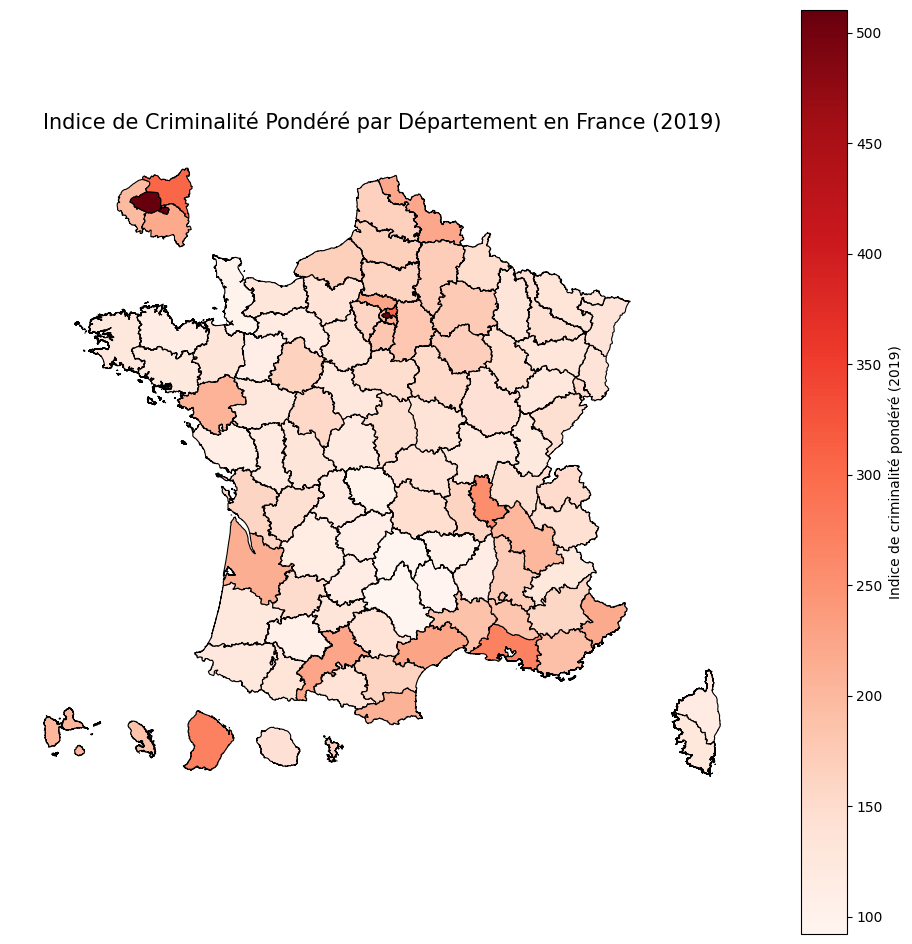

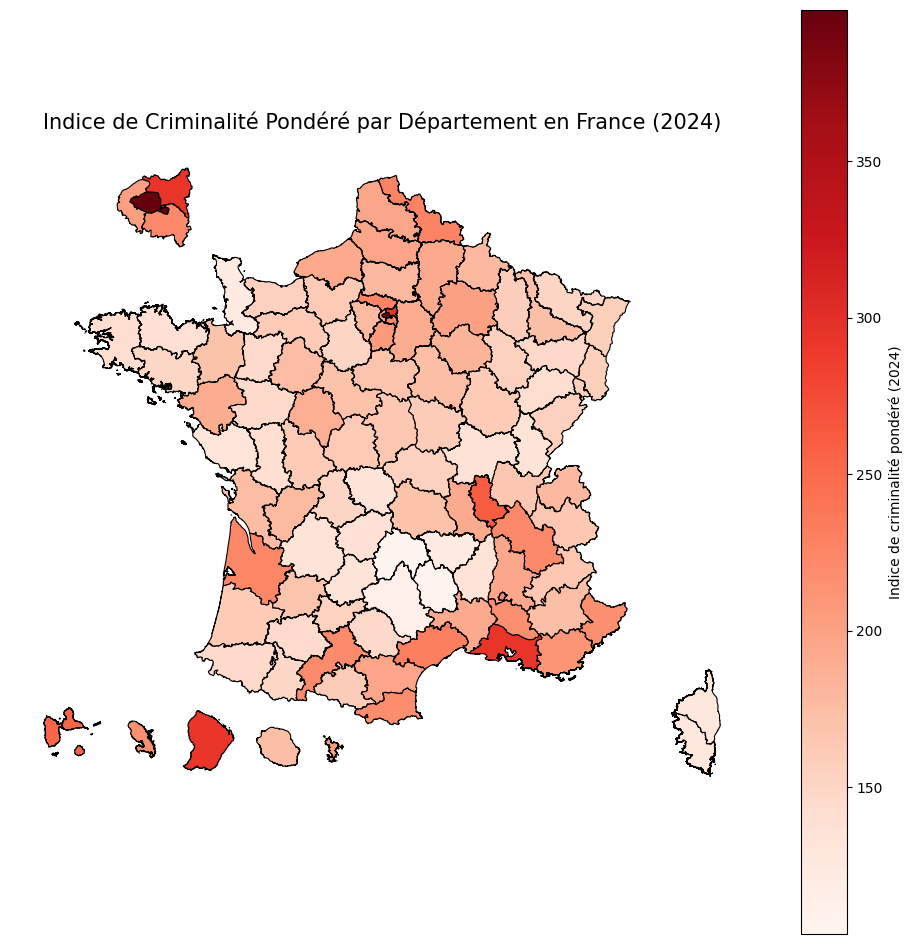

In [33]:
import matplotlib.pyplot as plt

# Plot for 2019 weighted crime index
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_weighted_crime_2019.plot(
    column='weighted_taux_pour_mille',
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Indice de criminalité pondéré (2019)", 'orientation': "vertical"}
)
ax.set_title("Indice de Criminalité Pondéré par Département en France (2019)", fontsize=15)
ax.set_axis_off()
plt.show()

# Plot for 2024 weighted crime index
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_weighted_crime_2024.plot(
    column='weighted_taux_pour_mille',
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Indice de criminalité pondéré (2024)", 'orientation': "vertical"}
)
ax.set_title("Indice de Criminalité Pondéré par Département en France (2024)", fontsize=15)
ax.set_axis_off()
plt.show()